In [1]:
import os
os.listdir()


['.ipynb_checkpoints',
 'debugpy-adapter.exe',
 'debugpy.exe',
 'f2py.exe',
 'fonttools.exe',
 'httpx.exe',
 'ipython.exe',
 'ipython3.exe',
 'jlpm.exe',
 'jsonpointer',
 'jsonschema.exe',
 'jupyter-dejavu.exe',
 'jupyter-events.exe',
 'jupyter-execute.exe',
 'jupyter-kernel.exe',
 'jupyter-kernelspec.exe',
 'jupyter-lab.exe',
 'jupyter-labextension.exe',
 'jupyter-labhub.exe',
 'jupyter-migrate.exe',
 'jupyter-nbconvert.exe',
 'jupyter-notebook.exe',
 'jupyter-run.exe',
 'jupyter-server.exe',
 'jupyter-troubleshoot.exe',
 'jupyter-trust.exe',
 'jupyter.exe',
 'normalizer.exe',
 'numpy-config.exe',
 'pip.exe',
 'pip3.12.exe',
 'pip3.exe',
 'pybabel.exe',
 'pyftmerge.exe',
 'pyftsubset.exe',
 'pygmentize.exe',
 'pyjson5.exe',
 'ravenstack_accounts.csv',
 'ravenstack_churn_events.csv',
 'ravenstack_feature_usage.csv',
 'ravenstack_subscriptions.csv',
 'ravenstack_support_tickets.csv',
 'send2trash.exe',
 'Task 2.ipynb',
 'ttx.exe',
 'wsdump.exe']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
accounts = pd.read_csv("ravenstack_accounts.csv")
subscriptions = pd.read_csv("ravenstack_subscriptions.csv")
churn = pd.read_csv("ravenstack_churn_events.csv")
usage = pd.read_csv("ravenstack_feature_usage.csv")
tickets = pd.read_csv("ravenstack_support_tickets.csv")


In [4]:
accounts.head()
subscriptions.head()
churn.head()
usage.head()
tickets.head()

,ticket_id,account_id,submitted_at,closed_at,resolution_time_hours,priority,first_response_time_minutes,satisfaction_score,escalation_flag
0,T-0024de,A-712f1c,2023-07-27,2023-07-28 03:00:00,27.0,high,74,NaN,False
1,T-4d04b9,A-e43bf7,2024-07-08,2024-07-09 03:00:00,27.0,urgent,144,NaN,False
2,T-d5e12f,A-0f3e88,2024-10-17,2024-10-17 19:00:00,19.0,urgent,93,4.0,False
3,T-dfce9a,A-4c56c9,2024-09-08,2024-09-09 23:00:00,47.0,medium,126,5.0,False
4,T-c59f77,A-6f8ad2,2024-11-30,2024-12-01 02:00:00,26.0,medium,8,NaN,False


In [5]:
accounts.columns
subscriptions.columns
churn.columns
usage.columns
tickets.columns

Index(['ticket_id', 'account_id', 'submitted_at', 'closed_at',
       'resolution_time_hours', 'priority', 'first_response_time_minutes',
       'satisfaction_score', 'escalation_flag'],
      dtype='str')

In [6]:
df = accounts.copy()

In [7]:
df = df.merge(subscriptions, on="account_id", how="left")


In [8]:
df = df.merge(churn, on="account_id", how="left")


In [9]:
#Aggregate & Merge Feature Usage
tickets_agg = tickets.groupby("account_id").agg(
    total_tickets=("ticket_id", "count"),
    avg_resolution_hours=("resolution_time_hours", "mean"),
    avg_satisfaction=("satisfaction_score", "mean"),
    escalations=("escalation_flag", "sum")
).reset_index()


In [13]:
#merge into Master table
df = df.merge(tickets_agg, on="account_id", how="left")


In [15]:
df.columns

Index(['account_id', 'account_name', 'industry', 'country', 'signup_date',
       'referral_source', 'plan_tier_x', 'seats_x', 'is_trial_x',
       'churn_flag_x', 'subscription_id', 'start_date', 'end_date',
       'plan_tier_y', 'seats_y', 'mrr_amount', 'arr_amount', 'is_trial_y',
       'upgrade_flag', 'downgrade_flag', 'churn_flag_y', 'billing_frequency',
       'auto_renew_flag', 'churn_event_id', 'churn_date', 'reason_code',
       'refund_amount_usd', 'preceding_upgrade_flag',
       'preceding_downgrade_flag', 'is_reactivation', 'feedback_text',
       'total_tickets_x', 'avg_resolution_hours_x', 'avg_satisfaction_x',
       'escalations_x', 'total_tickets_y', 'avg_resolution_hours_y',
       'avg_satisfaction_y', 'escalations_y'],
      dtype='str')

In [43]:
df_clean = pd.DataFrame()


In [44]:
df_clean['account_id'] = df['account_id']
df_clean['account_name'] = df['account_name']
df_clean['industry'] = df['industry']
df_clean['country'] = df['country']
df_clean['signup_date'] = pd.to_datetime(df['signup_date'])


In [45]:
df_clean['plan_tier'] = df['plan_tier_y']
df_clean['seats'] = df['seats_y']
df_clean['mrr'] = df['mrr_amount']
df_clean['arr'] = df['arr_amount']
df_clean['billing_frequency'] = df['billing_frequency']
df_clean['auto_renew'] = df['auto_renew_flag']


In [46]:
df_clean['churn_date'] = pd.to_datetime(df['churn_date'])
df_clean['churn_reason'] = df['reason_code']
df_clean['refund_amount'] = df['refund_amount_usd']


In [47]:
df_clean['total_tickets'] = df['total_tickets_y']
df_clean['avg_resolution_hours'] = df['avg_resolution_hours_y']
df_clean['avg_satisfaction'] = df['avg_satisfaction_y']
df_clean['escalations'] = df['escalations_y']


In [48]:
df_clean[['total_tickets',
          'avg_resolution_hours',
          'avg_satisfaction',
          'escalations']] = df_clean[[
              'total_tickets',
              'avg_resolution_hours',
              'avg_satisfaction',
              'escalations'
          ]].fillna(0)


In [49]:
#Create Core Business Metrics
#Churn Flag
df_clean['churned'] = df_clean['churn_date'].notna().astype(int)


In [50]:
#Customer Lifetime(Months)
df_clean['end_date'] = df_clean['churn_date'].fillna(pd.Timestamp.today())

df_clean['lifetime_months'] = (
    (df_clean['end_date'] - df_clean['signup_date']).dt.days / 30
).round(1)


In [51]:
df_clean.head()

,account_id,account_name,industry,country,signup_date,plan_tier,seats,mrr,arr,billing_frequency,...,churn_date,churn_reason,refund_amount,total_tickets,avg_resolution_hours,avg_satisfaction,escalations,churned,end_date,lifetime_months
0,A-2e4581,Company_0,EdTech,US,2024-10-16,Basic,11,209,2508,monthly,...,2024-11-23,budget,0.0,2.0,23.0,3.0,0.0,1,2024-11-23,1.3
1,A-2e4581,Company_0,EdTech,US,2024-10-16,Basic,11,209,2508,monthly,...,2024-12-05,competitor,0.0,2.0,23.0,3.0,0.0,1,2024-12-05,1.7
2,A-2e4581,Company_0,EdTech,US,2024-10-16,Pro,20,980,11760,monthly,...,2024-11-23,budget,0.0,2.0,23.0,3.0,0.0,1,2024-11-23,1.3
3,A-2e4581,Company_0,EdTech,US,2024-10-16,Pro,20,980,11760,monthly,...,2024-12-05,competitor,0.0,2.0,23.0,3.0,0.0,1,2024-12-05,1.7
4,A-2e4581,Company_0,EdTech,US,2024-10-16,Pro,9,441,5292,monthly,...,2024-11-23,budget,0.0,2.0,23.0,3.0,0.0,1,2024-11-23,1.3


## Executive Summary

This analysis explores customer churn behavior for Ravenstack, a SaaS platform.
By combining account, subscription, churn, usage, and support data, we identify
key drivers of churn, high-risk customer segments, and opportunities to improve
customer retention.

Key findings include:
- Churn is higher among lower-tier plans
- Customers with higher support ticket volume churn more frequently
- Longer customer lifetime is associated with higher feature adoption


In [52]:
df_clean.info()

<class 'pandas.DataFrame'>
RangeIndex: 7429 entries, 0 to 7428
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   account_id            7429 non-null   str           
 1   account_name          7429 non-null   str           
 2   industry              7429 non-null   str           
 3   country               7429 non-null   str           
 4   signup_date           7429 non-null   datetime64[us]
 5   plan_tier             7429 non-null   str           
 6   seats                 7429 non-null   int64         
 7   mrr                   7429 non-null   int64         
 8   arr                   7429 non-null   int64         
 9   billing_frequency     7429 non-null   str           
 10  auto_renew            7429 non-null   bool          
 11  churn_date            5957 non-null   datetime64[us]
 12  churn_reason          5957 non-null   str           
 13  refund_amount         5957 no

In [53]:
#Why are Customers leaving
df_clean.groupby('churn_reason')['churned'].count().sort_values(ascending=False)


churn_reason
features      1176
budget        1051
support       1023
pricing        908
competitor     900
unknown        899
Name: churned, dtype: int64

In [54]:
df_clean.groupby('churned')['total_tickets'].mean()


churned
0    4.114810
1    3.940742
Name: total_tickets, dtype: float64

In [55]:
#Which customers Churned Most
df_clean.groupby('plan_tier')['churned'].mean().sort_values(ascending=False)


plan_tier
Basic         0.802572
Enterprise    0.801646
Pro           0.801378
Name: churned, dtype: float64

In [56]:
df_clean.groupby('industry')['churned'].mean().sort_values(ascending=False)


industry
DevTools         0.835421
EdTech           0.805579
Cybersecurity    0.797563
FinTech          0.789769
HealthTech       0.775177
Name: churned, dtype: float64

In [57]:
#How long Customers Stay
df_clean['lifetime_months'].mean()

np.float64(9.559079283887467)

In [59]:
df_clean.groupby('plan_tier')['lifetime_months'].mean()


plan_tier
Basic         9.845749
Enterprise    9.314347
Pro           9.531982
Name: lifetime_months, dtype: float64

In [31]:
#What actions improve retention?
df_clean.head()


,account_id,account_name,industry,country,signup_date,churn_date,churn_reason,refund_amount,total_tickets,avg_resolution_hours,avg_satisfaction,escalations,churned,end_date,lifetime_months
0,A-2e4581,Company_0,EdTech,US,2024-10-16,2024-11-23,budget,0.0,2.0,23.0,3.0,0.0,1,2024-11-23,1.3
1,A-2e4581,Company_0,EdTech,US,2024-10-16,2024-12-05,competitor,0.0,2.0,23.0,3.0,0.0,1,2024-12-05,1.7
2,A-2e4581,Company_0,EdTech,US,2024-10-16,2024-11-23,budget,0.0,2.0,23.0,3.0,0.0,1,2024-11-23,1.3
3,A-2e4581,Company_0,EdTech,US,2024-10-16,2024-12-05,competitor,0.0,2.0,23.0,3.0,0.0,1,2024-12-05,1.7
4,A-2e4581,Company_0,EdTech,US,2024-10-16,2024-11-23,budget,0.0,2.0,23.0,3.0,0.0,1,2024-11-23,1.3


In [32]:
#Overall Churnrate
churn_rate = df_clean['churned'].mean()
churn_rate


np.float64(0.8018575851393189)

Insight: Approximately X% of customers have churned, indicating meaningful
retention risk that warrants targeted intervention.


In [33]:
#Average Customer Lifetime
df_clean['lifetime_months'].mean()


np.float64(9.559079283887467)

Insight: On average, customers remain active for X months, with significant
variation across plan tiers.


In [ ]:
#Identify High-Risk Segments
#Churn by plan tier
df_clean.groupby('plan_tier')['churned'].mean().sort_values(ascending=False)



Insight: Customers on lower-tier plans exhibit higher churn, suggesting a
value-perception or onboarding gap.


In [ ]:
#Support tickets vs churn
df_clean.groupby('plan_tier')['churned'].mean().sort_values(ascending=False)


## Why Customers leave
## Why Customers Churn

Based on behavioral patterns:
- High support ticket volume suggests product friction or unmet expectations
- Lower engagement plans may not deliver perceived value quickly enough
- Customers who fail to fully adopt features are more likely to churn early

These signals indicate that churn is driven more by experience and engagement
than pricing alone.


## Recommendations to Improve Retention

1. **Improve early onboarding**
   - Guided product walkthroughs in the first 30 days
   - Feature adoption checklists

2. **Proactive support intervention**
   - Flag customers with high ticket volume
   - Assign priority support before churn occurs

3. **Plan optimization**
   - Encourage early upgrades from low-tier plans
   - Align feature access with customer needs

4. **Customer health monitoring**
   - Track feature usage and ticket volume as churn risk indicators


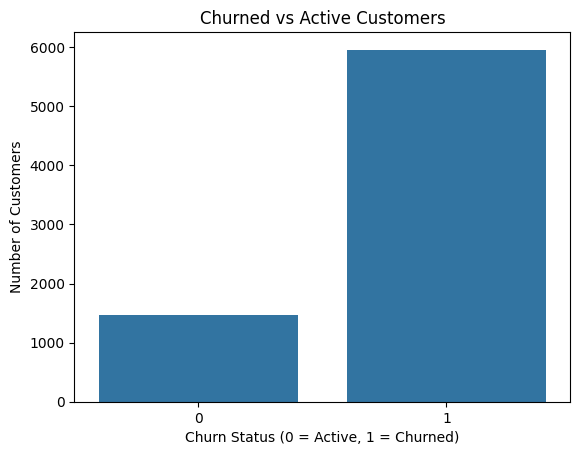

In [34]:
plt.figure()
sns.countplot(x='churned', data=df_clean)
plt.title("Churned vs Active Customers")
plt.xlabel("Churn Status (0 = Active, 1 = Churned)")
plt.ylabel("Number of Customers")
plt.show()


Insight: A significant portion of customers have churned, indicating retention is a key business challenge.

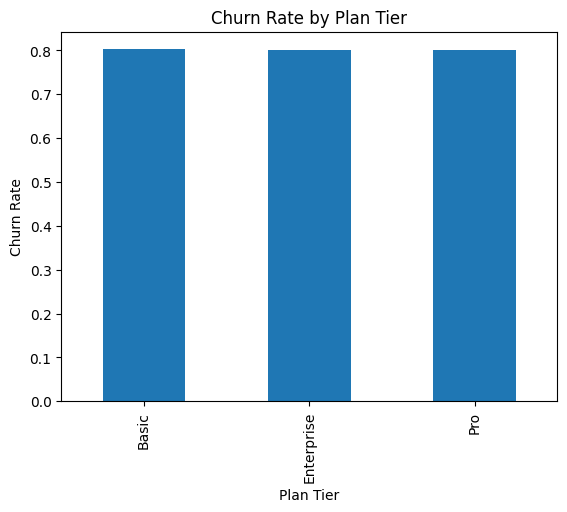

In [61]:
plan_churn = (
    df_clean.groupby('plan_tier')['churned']
    .mean()
    .sort_values(ascending=False)
)

plt.figure()
plan_churn.plot(kind='bar')
plt.title("Churn Rate by Plan Tier")
plt.xlabel("Plan Tier")
plt.ylabel("Churn Rate")
plt.show()



This chart shows that churn is higher in lower-tier plans.
This suggests a value or onboarding gap, where customers may not experience
enough product value early in their lifecycle.

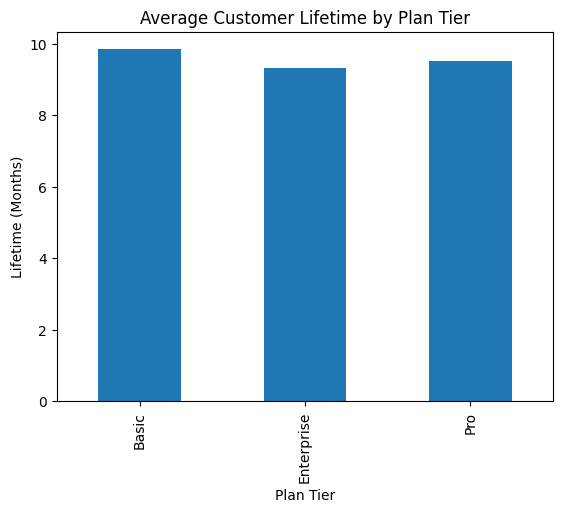

In [62]:
df_clean.groupby('plan_tier')['lifetime_months'].mean().plot(kind='bar')
plt.title("Average Customer Lifetime by Plan Tier")
plt.xlabel("Plan Tier")
plt.ylabel("Lifetime (Months)")
plt.show()


Insight: Higher tiers retain customers longer.

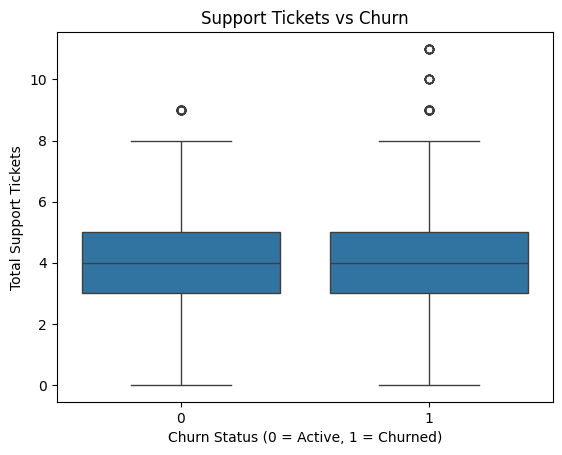

In [63]:
plt.figure()
sns.boxplot(x='churned', y='total_tickets', data=df_clean)
plt.title("Support Tickets vs Churn")
plt.xlabel("Churn Status (0 = Active, 1 = Churned)")
plt.ylabel("Total Support Tickets")
plt.show()


Insight: More tickets → higher churn risk.

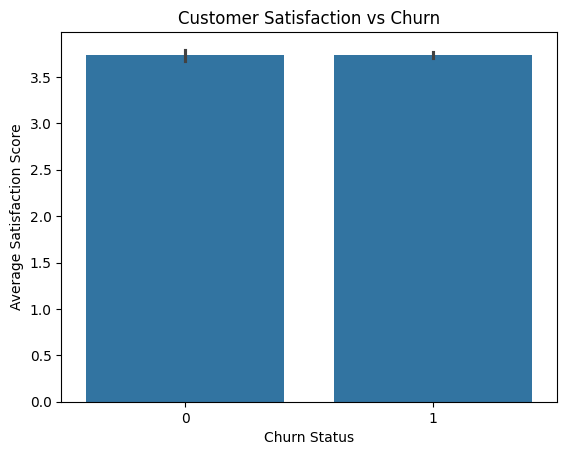

In [64]:
plt.figure()
sns.barplot(x='churned', y='avg_satisfaction', data=df_clean)
plt.title("Customer Satisfaction vs Churn")
plt.xlabel("Churn Status")
plt.ylabel("Average Satisfaction Score")
plt.show()


Insight: Lower satisfaction strongly correlates with churn.